<a href="https://colab.research.google.com/github/saja30/adult_repository/blob/main/Project_4_Part_1_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='pandas')
from sklearn.compose import make_column_transformer,make_column_selector,ColumnTransformer
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import BaggingRegressor,BaggingClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay,classification_report
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance
pd.set_option("display.float_format",lambda x:f"{x:,.2f}")
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.io as pio
import datetime as dt


In [119]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [120]:
file_name=("/content/drive/MyDrive/assignment/dult.csv")
df=pd.read_csv(file_name)
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [122]:
df.isna().sum().sum()

0

In [123]:
object_cols=df.select_dtypes("object").columns
object_cols

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country', 'income'],
      dtype='object')

In [124]:
for col in object_cols:
  print(f"{col}: {df[col].value_counts()}")

workclass: workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
education: education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64
marital-status: marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64
occupation: occupation
Prof-specialty       61

In [125]:
duplicated_rows=df.duplicated().sum()
duplicated_rows

52

In [126]:
df=df.drop_duplicates()

In [127]:
duplicated_rows=df.duplicated().sum()
duplicated_rows

0

In [128]:
null_values=df.isna().sum().sum()
null_values

0

In [129]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}")

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax
  def explore_numeric(df, x, figsize=(6,5) ):
  # Making our figure with gridspec for subplots
   gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])
  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])
  ## Adding a title
  axes[0].set_title(f"Column: {x}")
  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()
  ## Print message with info on the count and % of null values
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [130]:
def plot_categorical_vs_target(df, x, y='SalePrice',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


  def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
   corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

In [ ]:
explore_categorical(df,"income")

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. gender'}, xlabel='income', ylabel='Percent'>)

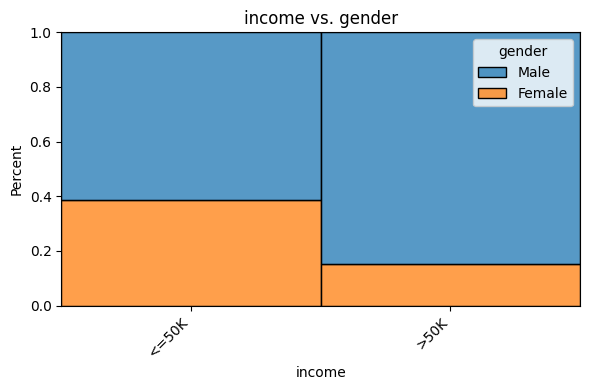

In [133]:
plot_categorical_vs_target(df,"income","gender",target_type="class")

# as seen from this figure female income >=50K more than female with income <50K

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'race vs. income'}, xlabel='race', ylabel='Percent'>)

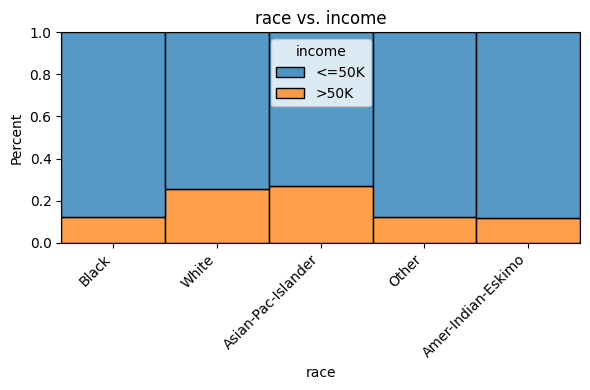

In [134]:
plot_categorical_vs_target(df,"race","income",target_type="class")

# I see there is no racism towards black and other races while there income >=50K

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'marital-status vs. income'}, xlabel='marital-status', ylabel='Percent'>)

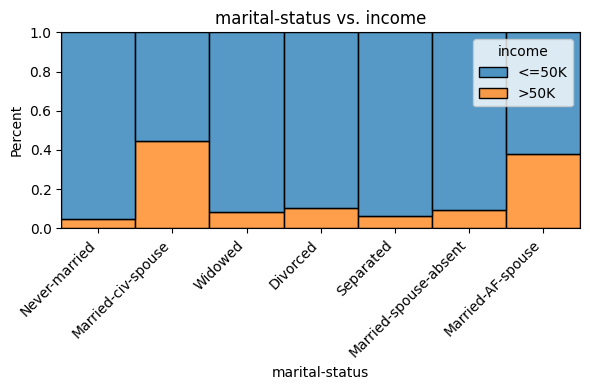

In [135]:
plot_categorical_vs_target(df,"marital-status","income",target_type="class")

# from this figure i see married_civ_spouse has the large percent approximately 5% with income <50K

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'education vs. income'}, xlabel='education', ylabel='Percent'>)

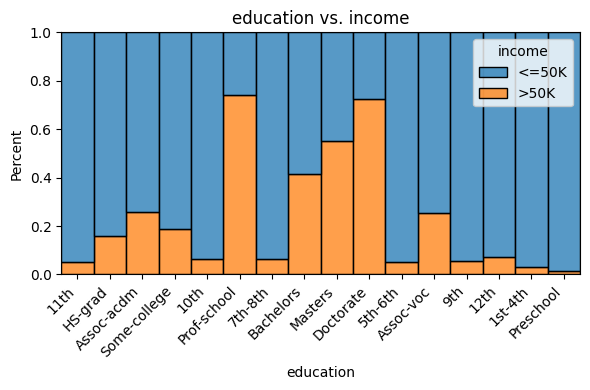

In [136]:
plot_categorical_vs_target(df,"education","income",target_type="class")

# AS i expected when education level increased the income >=50K will be increased

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. age'}, xlabel='income', ylabel='age'>)

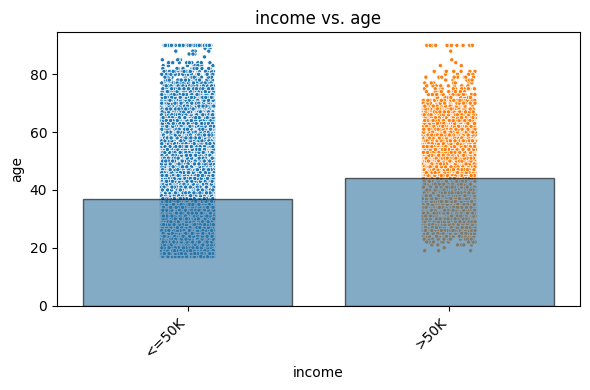

In [137]:
plot_categorical_vs_target(df,"income", y='age')

# i observe slightly difference between age avarage which indicates eldery people has lower income

# the target required to complete a classification task for this project so the target is "income" which has two categories
 - one row represent A dult person
 - 15 features does the data have


In [138]:
y=df["income"]
X=df.drop("income",axis=1)

In [139]:
# instantiate model validation
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42)

In [140]:
# greate object columns & processing
num_cols=X_train.select_dtypes("number").columns
num_scale=StandardScaler()
num_pipe=make_pipeline(num_scale)
num_tuple=("numeric",num_pipe,num_cols)



In [169]:
cat_cols=X_train.select_dtypes("object").columns
cat_ohe=OneHotEncoder(handle_unknown="ignore",sparse=False)
cat_pipe=make_pipeline(cat_ohe)
cat_tuple=("categorical",cat_pipe,cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False))]),
 Index(['workclass', 'education', 'marital-status', 'occupation',
        'relationship', 'race', 'gender', 'native-country'],
       dtype='object'))

In [170]:
preprocessor=ColumnTransformer([num_tuple,cat_tuple],verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [171]:
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'gender', 'native-country'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [172]:
feature_names=preprocessor.get_feature_names_out()
feature_names

array(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_?', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Never-worked',
       'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Preschool', 'education_Prof-school',
       'education_Some-college', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent',
       'marital-status_Never-married', 'marital-status_Separated',
       'marital-status_Widowed', 'occupation_

In [185]:
X_train_tf=pd.DataFrame(preprocessor.transform(X_train),columns=feature_names,index=X_train.index)
X_test_tf=pd.DataFrame(preprocessor.transform(X_test),columns=feature_names,index=X_test.index)


In [174]:
X_train_tf.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
38093,3.17,0.04,0.36,-0.15,-0.22,-2.61,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
43391,-0.63,-1.34,1.52,-0.15,-0.22,0.77,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3064,-0.78,1.42,-0.42,0.26,-0.22,0.37,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
45606,-1.36,-0.53,-0.03,-0.15,-0.22,-2.05,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2116,0.02,-1.16,-0.42,-0.15,-0.22,-0.04,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


In [175]:
# check fo target balance
y.value_counts(1)

income
<=50K   0.76
>50K    0.24
Name: proportion, dtype: float64

In [176]:
# using SMOTE to make data Balanced
smote=SMOTE(random_state=42)
X_train_sm,y_train_sm=smote.fit_resample(X_train_tf,y_train)

In [177]:
y_train_sm.value_counts()

income
<=50K    27841
>50K     27841
Name: count, dtype: int64

In [178]:
# choose a model
rf=RandomForestClassifier(random_state=42)
rf.fit(X_train_sm,y_train_sm)


RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       1.00      1.00      1.00     27841
        >50K       1.00      1.00      1.00     27841

    accuracy                           1.00     55682
   macro avg       1.00      1.00      1.00     55682
weighted avg       1.00      1.00      1.00     55682



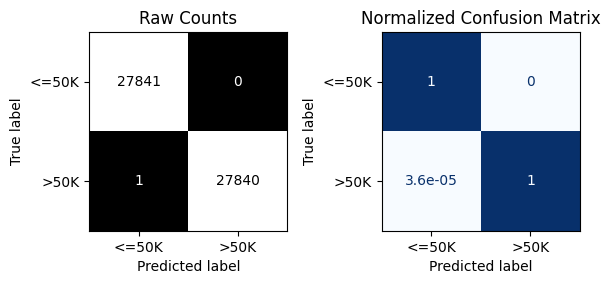


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

       <=50K       0.90      0.89      0.90      9268
        >50K       0.68      0.69      0.68      2930

    accuracy                           0.85     12198
   macro avg       0.79      0.79      0.79     12198
weighted avg       0.85      0.85      0.85     12198



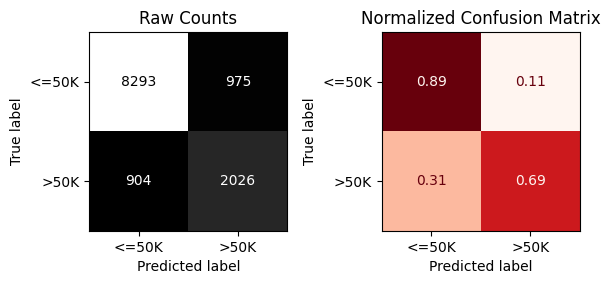

In [179]:
# evaluate default model
evaluate_classification(rf,X_train_sm,y_train_sm,X_test_tf,y_test)

# ther is overfit obviously in our data with accuracy=.85 for testing data & accuracr=1 for training data

In [184]:
from sklearn.inspection import permutation_importance
# Permutation importance takes a fit model and the test data.
r = permutation_importance(rf,X_test_tf,y_test ,n_repeats =5,random_state =42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [188]:
permutation_importances = pd.Series(r['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

capital-gain                         0.03
age                                  0.01
educational-num                      0.01
capital-loss                         0.01
marital-status_Married-civ-spouse    0.01
                                     ... 
marital-status_Divorced             -0.00
occupation_Craft-repair             -0.00
relationship_Not-in-family          -0.00
marital-status_Never-married        -0.00
relationship_Husband                -0.01
Name: permutation importance, Length: 108, dtype: float64

[Text(0.5, 1.0, 'Feature Importance'),
 Text(0.5, 0, 'Importance'),
 Text(0, 0.5, 'Feature')]

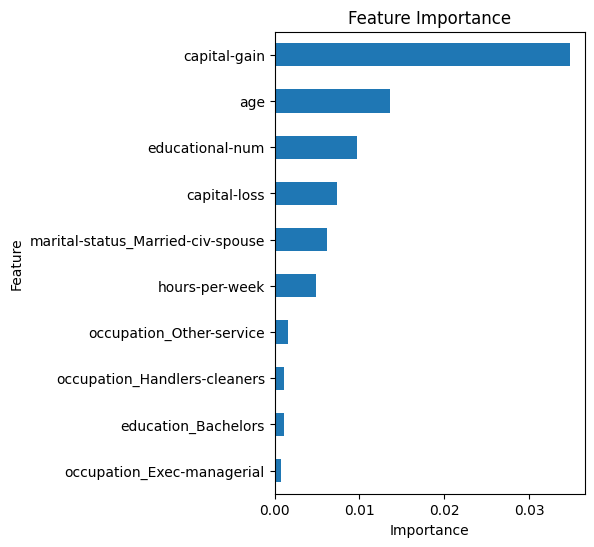

In [189]:
ax=permutation_importances.sort_values().tail(10).plot(kind='barh',figsize=(4,6))
ax.set(title="Feature Importance",xlabel="Importance",ylabel="Feature")

In [190]:
plot_train=pd.concat([y_train_sm,X_train_sm],axis=1)
plot_test=pd.concat([y_test,X_test_tf],axis=1)
plot_df=pd.concat([plot_train,plot_test],axis=0)
plot_df.head()

,income,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,<=50K,3.17,0.04,0.36,-0.15,-0.22,-2.61,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
1,>50K,-0.63,-1.34,1.52,-0.15,-0.22,0.77,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
2,<=50K,-0.78,1.42,-0.42,0.26,-0.22,0.37,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,<=50K,-1.36,-0.53,-0.03,-0.15,-0.22,-2.05,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,<=50K,0.02,-1.16,-0.42,-0.15,-0.22,-0.04,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. capital-gain'}, xlabel='income', ylabel='capital-gain'>)

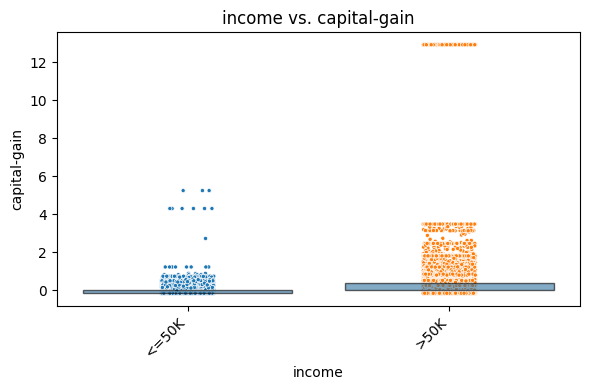

In [191]:
plot_categorical_vs_target(plot_df,"income",y='capital-gain')

# I observe from this figure  avarage income<50K is higher when capita_gain increased

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'income vs. age'}, xlabel='income', ylabel='age'>)

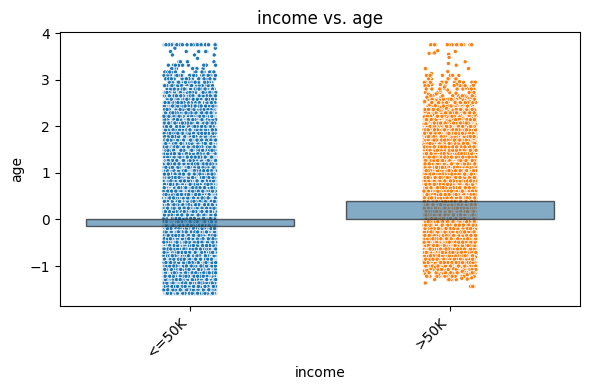

In [194]:
plot_categorical_vs_target(plot_df,"income",y='age')

# I observe avarage income <50K for eldery people